# Classification of bird sound files

<div class="alert alert-warning">
<strong>This notebook assume that the conversion of MP3 files into WAV files has been already done.</strong>

If not, please check the other notebook *birds_sound_visualizations.ipynb*
</div>

From literature, we have found several methods to classify sounds depending on the bird species:

- Logistic Regression
- k Nearest Neighbour (kNN) classifier with histogram-based features
- Support Vector Machines (SVM) with time-summarisation features
- Random Forest

We want a supervised classification, according to the litterature for bird sound SVM and KNN, due to their widespread use and ease of interpretation, will be the best method but it is interesting to compare them to other method thanks to an accuracy value.

The strategy here is to first create a dataframe with all the needed features from the bird sound recording that have been previously converted into wav file. Now that we have our labeled database of previously known bird songs, we use it to create a decision procedure that is used to predict the species of a new bird song.  

### Import libraries

In [8]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [9]:
from data.loader import get_kasios_obs, get_obs, map_path

### Create Dataframes

In [10]:
df_all = get_obs(songs = True)

# Create a new column to tell whether it's a blue pipit or not 
# this is our target for the classification
df_all['Type'] = (df_all['English_name'] == 'Rose-crested Blue Pipit').astype(np.int)


df_all_show = df_all.groupby('Type')
df_all_show = df_all_show.apply(lambda x: x.sample(frac=0.3))
display(df_all_show)

Loading wav files...
Done.


English_name Vocalization_type   Quality    Time  \
Type File ID                                                                   
0    239649           Orange Pine Plover              song         C   14:00   
     63314            Bent-beak Riffraff              song         B     ?:?   
     100556           Eastern Corn Skeet              song         B  7:30am   
     168013           Orange Pine Plover              call         B    7:30   
     359165   Green-tipped Scarlet Pipit              song  no score    8:30   
     110105            Lesser Birchbeere              call         A   13:00   
     344336             Darkwing Sparrow              call         A    6:35   
     67163            Orange Pine Plover              song         B       ?   
     4626                    Scrawny Jay              Call         C    8:53   
     395909      Carries Champagne Pipit              call         A   11:00   
     235138                   Queenscoat              song         B   13:30   
     281366                   Queenscoat              call         B   12:30   
     397347          Vermillion Trillian              call         B   14:00   
     60257    Green-tipped Scarlet Pipit              song         A     ?:?   
     160292            Lesser Birchbeere              call         B    6:49   
     61218                   Scrawny Jay              call         B      am   
     396464             Darkwing Sparrow              call         A    9:00   
     329010            Lesser Birchbeere              call         B   17:42   
     42103                           Qax              song         A       ?   
     145938           Orange Pine Plover              call         A    8:29   
     309652          Vermillion Trillian              song         B    9:00   
     114773          Purple Tooting Tout        call, song         B    6:30   
     199659                   Queenscoat              call         C    6:00   
     50740                           Qax              song         A     ?:?   
     321383            Lesser Birchbeere        call, song         A    6:15   
     169203            Lesser Birchbeere              call         A    8:51   
     51417                   Scrawny Jay              song         A    6:56   
     235428           Eastern Corn Skeet              song         C   15:00   
     370601                          Qax              song  no score    9:00   
     282287           Orange Pine Plover              song         B   19:00   
...                                  ...               ...       ...     ...   
1    191415      Rose-crested Blue Pipit              call         B    9:00   
     345551      Rose-crested Blue Pipit              song         D    9:34   
     191515      Rose-crested Blue Pipit              song         B    8:00   
     169033      Rose-crested Blue Pipit              call         C   10:00   
     35964       Rose-crested Blue Pipit              call         A   15:30   
     134755      Rose-crested Blue Pipit              song         C   11:00   
     18970       Rose-crested Blue Pipit              song         D    8:00   
     255560      Rose-crested Blue Pipit              call         B    7:50   
     345802      Rose-crested Blue Pipit              song         B    8:04   
     161630      Rose-crested Blue Pipit              song         C   10:00   
     118321      Rose-crested Blue Pipit              call         A   15:20   
     306340      Rose-crested Blue Pipit              song         E   13:00   
     162562      Rose-crested Blue Pipit                 ?         B   21:15   
     345559      Rose-crested Blue Pipit              call         B   11:40   
     345564      Rose-crested Blue Pipit              call         B   14:45   
     351273      Rose-crested Blue Pipit              call         A   13:00   
     222805      Rose-crested Blue Pipit              song         C   10:00   
     162567      Rose-creste

In [11]:
# Read all sounds files
sounds_all = []
for i, (index, obs) in enumerate(df_all_show.iterrows()):
    # read wav file
    rate, data = wavfile.read(obs["song"])
    sounds_all.append(data[:500000])

In [12]:
# Read the tests sounds of Kasios
df_test = get_kasios_obs(songs = True)

sounds_test = []
for i, (index, obs) in enumerate(df_test.iterrows()):
    rate, data = wavfile.read(obs["song"])
    sounds_test.append(data[:500000])

Loading wav files...
Done.


In [13]:
# Compute 4 parameters for all sounds
mean_all = []
std_all = []
min_all = []
max_all = []

for sound in sounds_all:
    mean_all.append(np.mean(sound))
    std_all.append(np.std(sound))
    min_all.append(np.min(sound))
    max_all.append(np.max(sound))

df_all_show = df_all_show.assign(mean=mean_all, std=std_all, 
                                 min=min_all, max=max_all)

df_all_show.head()

English_name Vocalization_type   Quality    Time  \
Type File ID                                                                   
0    239649           Orange Pine Plover              song         C   14:00   
     63314            Bent-beak Riffraff              song         B     ?:?   
     100556           Eastern Corn Skeet              song         B  7:30am   
     168013           Orange Pine Plover              call         B    7:30   
     359165   Green-tipped Scarlet Pipit              song  no score    8:30   

                   Date   X    Y    color          T  \
Type File ID                                           
0    239649    5/2/2015  62   43  #8c564b 2015-05-02   
     63314    9/11/2001  68   85  #1f77b4 2001-09-11   
     100556    5/4/2012  83  126  #ff9896 2012-05-04   
     168013   4/26/2007  91   60  #8c564b 2007-04-26   
     359165   3/11/2017  75  151  #9467bd 2017-03-11   

                                                           song  Type  \
Type File ID                                                            
0    239649   /home/sajeevan/Bureau/vast-challenge-2018-mc1/...     0   
     63314    /home/sajeevan/Bureau/vast-challenge-2018-mc1/...     0   
     100556   /home/sajeevan/Bureau/vast-challenge-2018-mc1/...     0   
     168013   /home/sajeevan/Bureau/vast-challenge-2018-mc1/...     0   
     359165   /home/sajeevan/Bureau/vast-challenge-2018-mc1/...     0   

                   mean          std    min    max  
Type File ID                                        
0    239649    9.933106  3118.809314 -14860  14744  
     63314   -12.910590  4739.960441 -31475  31394  
     100556   -0.227554  2697.848565 -27571  27647  
     168013   -0.216574   381.218379  -4620   4932  
     359165   -5.937938   721.947193  -8908   9757

In [14]:
# Compute 4 parameters for test sounds
mean_test = []
std_test = []
min_test = []
max_test = []

for sound in sounds_test:
    mean_test.append(np.mean(sound))
    std_test.append(np.std(sound))
    min_test.append(np.min(sound))
    max_test.append(np.max(sound))

df_test = df_test.assign(mean=mean_test, std=std_test, 
                         min=min_test, max=max_test)

df_test.head()

,X,Y,song,mean,std,min,max
ID,,,,,,,
1,140,119,/home/sajeevan/Bureau/vast-challenge-2018-mc1/...,-0.524770,535.062343,-5181,4709
2,63,153,/home/sajeevan/Bureau/vast-challenge-2018-mc1/...,-2.085266,911.055410,-6526,6506
3,70,136,/home/sajeevan/Bureau/vast-challenge-2018-mc1/...,-0.331892,347.067326,-3850,3794
4,78,150,/home/sajeevan/Bureau/vast-challenge-2018-mc1/...,-0.073872,685.782020,-8716,8549
5,60,90,/home/sajeevan/Bureau/vast-challenge-2018-mc1/...,-1.817126,823.384616,-6128,5957


### k Nearest Neighbour (k-NN) classifier

#### 1) Training Model

In [15]:
X_sample = df_all_show.drop(columns=['Quality', 'English_name', 
                                     'Vocalization_type', 'Time', 'Date', 
                                     'Type', 'song', 'T', 'color'])

X = []

y = list(df_all_show["Type"])

for row in X_sample.iterrows():
    index, data = row
    X.append(data.tolist())

In [16]:
# k-NN training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [17]:
# Accuracy of the model
accuracy = clf.score(X_test, y_test)
print("Accuracy of the model: %s" % accuracy)

# Confusion matrix
y_predict= clf.predict(X_test)
print("Confusion matrix: \n%s" % confusion_matrix(y_test, y_predict))

Accuracy of the model: 0.8467741935483871
Confusion matrix: 
[[105   3]
 [ 16   0]]


#### 2) Predicting on Kasios test sounds 

In [18]:
X_kasios = []

for row in df_test.drop(columns=['song']).iterrows():
    index, data = row
    X_kasios.append(data.tolist())

In [35]:
kasios_prediction = clf.predict(X_kasios)
for i in range(len(kasios_prediction)):
    print("Sound test %s - Prediction : %s" % (i+1, kasios_prediction[i]))

Sound test 1 - Prediction : 0
Sound test 2 - Prediction : 0
Sound test 3 - Prediction : 0
Sound test 4 - Prediction : 0
Sound test 5 - Prediction : 0
Sound test 6 - Prediction : 0
Sound test 7 - Prediction : 0
Sound test 8 - Prediction : 0
Sound test 9 - Prediction : 0
Sound test 10 - Prediction : 0
Sound test 11 - Prediction : 0
Sound test 12 - Prediction : 0
Sound test 13 - Prediction : 0
Sound test 14 - Prediction : 0
Sound test 15 - Prediction : 0


<div class='alert alert-info'>
According to our <b>k-NN classifier</b>, only the 12th Kasios test sound <b>seems</b> to be Blue Pipit one.
<div>  

### Support Vector Machine (SVM) classifier

#### 1) Training Model

In [36]:
x_list = np.linspace(2**-5, 2**5, 30)
accuracy_C = []
for x in x_list:
    model = svm.SVC(kernel='linear', C=x)
    model.fit(X_train, y_train)
    accuracy_C.append(model.score(X_test, y_test))
x = 0

# select the C with max accuracy
max_index = accuracy_C.index(max(accuracy_C))
C_chosed = x_list[max_index]

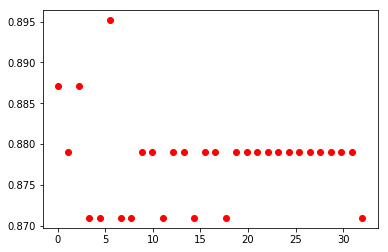

In [37]:
plt.plot(x_list, accuracy_C, 'ro')
plt.show()

In [38]:
# we do the same thing for gamma

accuracy_gamma = []
for x in x_list:
    model = svm.SVC(kernel='linear', C=C_chosed, gamma=x)
    model.fit(X_train, y_train)
    accuracy_gamma.append(model.score(X_test, y_test))

# to find the C with the max accuracy
max_index = accuracy_gamma.index(max(accuracy_gamma))
gamma_chosed = x_list[max_index]  # the C that we will choose

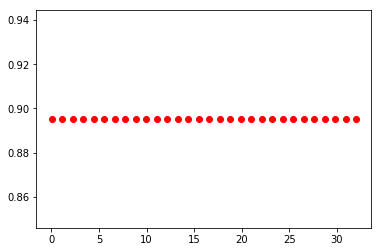

In [40]:
plt.plot(x_list, accuracy_gamma, 'ro')
plt.show()

In [41]:
# We can now define our SVM model
model = svm.SVC(kernel='linear', C=C_chosed, gamma=gamma_chosed)
model.fit(X_train, y_train)

SVC(C=5.543103448275862, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.03125, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
# Accuracy of the model
accuracy = model.score(X_test, y_test)
print("Accuracy of the model: %s" % accuracy)

# Confusion matrix
y_predict = model.predict(X_test)
print("Confusion matrix: \n%s" % confusion_matrix(y_test, y_predict))

Accuracy of the model: 0.8951612903225806
Confusion matrix: 
[[107   1]
 [ 12   4]]


#### 2) Predicting on Kasios test sounds 

In [58]:
kasios_prediction = model.predict(X_kasios)
for i in range(len(kasios_prediction)):
    print("Sound test %s - Prediction : %s" % (i+1, kasios_prediction[i]))

Sound test 1 - Prediction : 0
Sound test 2 - Prediction : 0
Sound test 3 - Prediction : 0
Sound test 4 - Prediction : 0
Sound test 5 - Prediction : 0
Sound test 6 - Prediction : 0
Sound test 7 - Prediction : 0
Sound test 8 - Prediction : 0
Sound test 9 - Prediction : 0
Sound test 10 - Prediction : 0
Sound test 11 - Prediction : 0
Sound test 12 - Prediction : 0
Sound test 13 - Prediction : 0
Sound test 14 - Prediction : 0
Sound test 15 - Prediction : 0


<div class='alert alert-info'>
According to our <b>SVM classifier</b>, only the 11th test sound from Kasios <b>seems</b> to be a Rose crested Blue Pipit.
<div>  